In [1]:
# Plotting
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_palette("bright")

# Random sklearn stuff
from sklearn.cluster import KMeans, MeanShift
from sklearn.ensemble import RandomForestClassifier
from IPython.display import clear_output # For looping but only printing each loop

# The tomo challege package and metrics
import tomo_challenge as tc
from tomo_challenge.jax_metrics import compute_snr_score, compute_fom

# Built in library
import time
from itertools import permutations

# Jax imports, and turn on 64 bit
from jax import grad
import jax
import jax.numpy as jnp
import jax.config as config
from jax.core import UnexpectedTracerError
config.update("jax_enable_x64", True)


np.random.seed(1985)
gen = np.random.RandomState(seed=1985)

Found classifier Random
Found classifier IBandOnly
Found classifier PCAForest
Found classifier RandomForest


In [2]:
d_loc = "data"
x_train = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/training.hdf5", "griz", colors=True, errors=True))
z_train = tc.load_redshift(f"{d_loc}/training.hdf5")

/Users/dylan/repos/tomo_challenge/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [3]:
color_data = x_train[["r", "gr", "ri", "rz"]].to_numpy()
errs = x_train[["r_err"]].to_numpy()

err_thresh = 0.01
err_cond = errs >= err_thresh
weights = np.where(errs < err_thresh, 1, 1/errs**2)
weights[err_cond] = weights[err_cond] / np.max(weights[err_cond])

In [4]:
# Make the mean zero then find the covariance matrix
# divde by len-1 because sample and not population covariance
# First line is unweighted mean, second is the weighted average.
# color_shifted = color_data - np.mean(color_data, axis=0)
color_shifted = color_data - np.average(color_data[:,0].reshape(-1, 1), weights=weights)
cov = color_shifted.T @ color_shifted / (color_shifted.shape[0] - 1)

# Find the eigen values and eigen vectors of the covariance matrix
# The eigen vectors are vertical!
# Eigen vectors are principal components of dataset
eigen_variance, eigen_matrix = np.linalg.eig(cov)

# Sorting so we make sure that the vectors are in order of importance
eigen_matrix = eigen_matrix[np.argsort(-eigen_variance)]
eigen_variance = eigen_variance[np.argsort(-eigen_variance)]

24.139006057450977
22.371130249024198


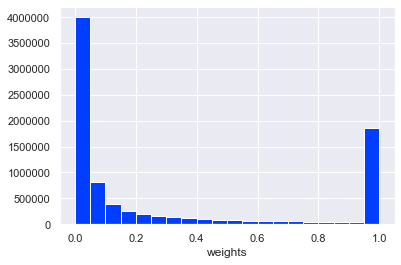

In [5]:
# plt.hist(errs[errs < 30], bins=15)
plt.hist(weights, bins=20)
plt.xlabel("weights")
# print(weights.max())
# print(weights.min())

print(np.mean(color_data[:,0]))
print(np.average(color_data[:,0].reshape(-1, 1), weights=weights))

In [6]:
def find_eigenvector(data, weights=None):
    # Start with position 1985. 1985 is the year my favourite
    # movie came out. No other reason than that. 
    phi = data[1985].reshape(1, -1)
    
    if weights is None:
        weights = np.ones_like(phi)

    thresh = 1e-6
    cond = False
    i = 0
    while not cond:
        # Find the coefficients that match the eigen vector to the data vector
        coeffs = data @ phi.T

        # Project the data along phi axis by multiplying the data by the coefficient
        proj = data * coeffs * weights

        # Sum all the projected ones to find the new eigenvector and then divide by the
        # length of the vector to reduce it to unit vector length.
        phi_new = np.sum(proj, axis=0)
        phi_new = phi_new / np.linalg.norm(phi_new)

        # If all of the dimensions changes by less than thresh then the
        # condition is set to true and the loop breaks
        cond = np.all((phi_new - phi) < thresh)

        phi = phi_new.reshape(1, -1)
        i += 1
    print("Iterations:", i + 1)
    return phi

In [7]:
eigs = []
num_eigs = 4
eigs = np.zeros((num_eigs, color_shifted.shape[1]))
temp_data = np.copy(color_shifted)
for i in range(num_eigs):
    v = find_eigenvector(temp_data, None)
    eigs[:,i] = (v)
    
    # Subtract the projections of the first eigen vector to start finding the next one.
    coeffs = temp_data @ v.T
    temp_data = temp_data - coeffs * v

print(eigs)
print(eigen_matrix)
# Closeness assertions for testing purposes.
# assert np.allclose(eigs[:,0], eigen_matrix[:,0]) or np.allclose(-eigs[:,0], eigen_matrix[:,0], atol=1e-3)
# assert np.allclose(eigs[:,1], eigen_matrix[:,1]) or np.allclose(-eigs[:,1], eigen_matrix[:,1], atol=1e-3)
# assert np.allclose(eigs[:,2], eigen_matrix[:,2]) or np.allclose(-eigs[:,2], eigen_matrix[:,2], atol=1e-3)
# assert np.allclose(eigs[:,3], eigen_matrix[:,3]) or np.allclose(-eigs[:,3], eigen_matrix[:,3], atol=1e-3)

Iterations: 4
Iterations: 11
Iterations: 8
Iterations: 3
[[ 0.0471107   0.99857377 -0.02047592  0.01455131]
 [-0.57526083  0.01125107 -0.81585551 -0.05769038]
 [-0.58179452  0.02417952  0.35897862  0.72942775]
 [-0.57303638  0.04625134  0.45287402 -0.68146551]]
[[ 0.0471107  -0.99857377 -0.0204758  -0.01455131]
 [-0.57526083 -0.01125117 -0.8158555   0.05769042]
 [-0.58179452 -0.02417947  0.35897858 -0.72942777]
 [-0.57303638 -0.04625128  0.45287406  0.68146548]]


[0.99790122 0.99964486 0.9999619  1.        ]


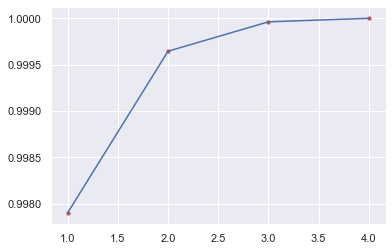

In [8]:
# Plots the amount of variance in the data explained by the number
# of principal components chosen.
x = np.arange(0, len(eigen_variance)) + 1
y = np.cumsum(eigen_variance) / np.sum(eigen_variance)

plt.plot(x, y, c="b")
plt.scatter(x, y, s=10, c="r")
print(y)

In [15]:
# The selection of principal axis vectors that will reduce dimensionality
reducer = eigs[:, 0:3]
# reducer = eigen_matrix[0:2].T
data_reduced = color_data @ reducer

# I took this cut from the random forest example.
# I cut after doing the PCA in case the cut changes the
# principal axes and I want to avoid that.
cut = np.random.uniform(0, 1, data_reduced.shape[0]) < 0.05
data_cut =  data_reduced[cut]
z_cut = z_train[cut]

Text(0, 0.5, 'z')

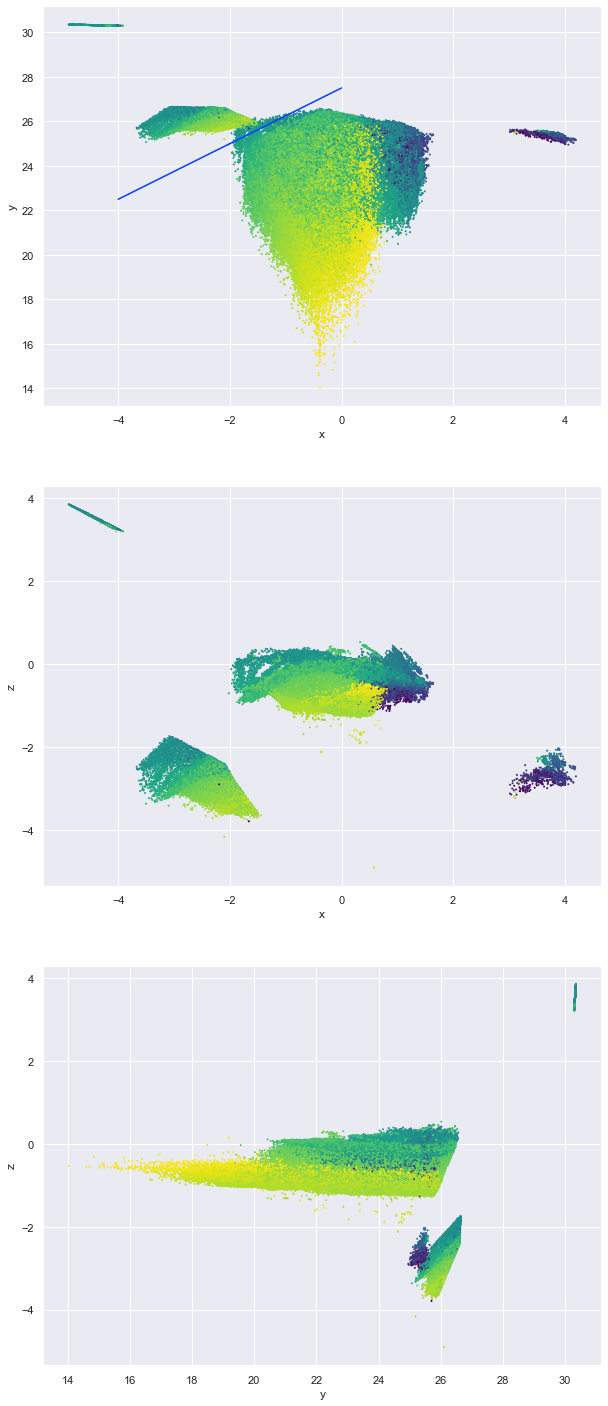

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(10, 25))

# Plotting data itself.
ax[0].scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=z_train[cut], cmap="viridis_r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
def reg(x):
    return (x) * 5/4 + 27.5
ax[0].plot([-4, 0], reg(np.asarray([-4, 0])))
# ax[0].colorbar().set_label("redshift")

ax[1].scatter(data_cut[:, 0], data_cut[:, 2], s=1, c=z_train[cut], cmap="viridis_r")
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")
# ax[1].colorbar().set_label("redshift")

ax[2].scatter(data_cut[:, 1], data_cut[:, 2], s=1, c=z_train[cut], cmap="viridis_r")
# ax[2].colorbar().set_label("redshift")
ax[2].set_xlabel("y")
ax[2].set_ylabel("z")

In [11]:
def softmax(x):
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=0)

def d2(points, centroids, z):
    # Finds the distance between the points and the centroids
    dist = []
    for center in centroids:
        shift = points - center
        dist.append(jnp.linalg.norm(shift, axis=1))

    # Converting to numpy array so we can use boolean indexing
    dist = jnp.asarray(dist)
    
    # Which category these would be assigned to based on their distances
    # soft min, don't have to one_hot then and the gradient should work.
    cat = softmax(-dist).T 
#     return -compute_snr_score(cat, z, binned_nz=True)
    return compute_fom(cat, z, binned_nz=True)

In [26]:
def fit_centroids(points, redshift, num_centroids=3, num_epochs=10):
    ind = gen.randint(0, len(points), num_centroids)
    # Must shift by a little so we don't get nan gradients due to 0 distances
    centroids = points[ind].astype("float32") + (np.ones_like(points[0]) / 100)
    snr_history = []
    
    # Store the total gradient so we can use momentum.
    total_grad = np.zeros_like(centroids)
    cur_grad = np.ones_like(centroids)
    c_0 = np.copy(centroids)
    i = 0
    delta_snr = 1
    
    # Terminate at the number of epochs or if the change in snr is 
    # too small to be meaningful
    while i < num_epochs and abs(delta_snr) > 0.20:
        try:
            print("Epoch", i + 1)
            snr, grads = jax.value_and_grad(d2, 1)(points, centroids, redshift)
            snr_history.append(-snr)
            print("FOM", -snr)  
            total_grad = grads + 0.9 * total_grad # Momentum baby
            centroids += -(total_grad)*(1000*num_centroids/points.size)

            i += 1
            if len(snr_history) > 1:
                delta_snr = -snr - snr_history[-2]
                print(delta_snr)
        except UnexpectedTracerError:
            print("Tracer Error, retrying epoch")
            continue

    print("Final FOM", -d2(points, centroids, redshift))
    plt.plot(np.arange(0, len(snr_history)) + 1, snr_history, label=num_centroids)
    return centroids

def classify(points, centroids):
    # Finds the distance between the points and the centroids
    dist = []
    for center in centroids:
        shift = points - center
        dist.append(jnp.linalg.norm(shift, axis=1))

    # Converting to numpy array so we can use boolean indexing
    dist = jnp.asarray(dist)

    # Which category these would be assigned to based on their distances
    return jnp.argmin(dist, axis=0)

Epoch 1
FOM 675.2468677872228
Epoch 2
Tracer Error, moving to next epoch
Epoch 2
FOM 677.1934244984501
1.9465567112273447
Epoch 3
FOM 682.1599735269458
4.966549028495706
Epoch 4
FOM 692.5134115940622
10.353438067116372
Epoch 5
FOM 710.6443205843641
18.13090899030192
Epoch 6
FOM 734.1274723154204
23.483151731056296
Epoch 7
FOM 754.2422913195729
20.114819004152537
Epoch 8
FOM 766.7609803247367
12.518689005163765
Epoch 9
FOM 774.0965085281399
7.335528203403214
Epoch 10
FOM 778.7677630898045
4.671254561664568
Epoch 11
FOM 782.2637748861575
3.4960117963530593
Epoch 12
FOM 785.4107992178162
3.147024331658713
Epoch 13
FOM 788.6880407425833
3.277241524767078
Epoch 14
FOM 792.3732029013752
3.6851621587918544
Epoch 15
FOM 796.5866485388772
4.213445637501991
Epoch 16
FOM 801.2783929305795
4.6917443917022865
Epoch 17
FOM 806.2004980638646
4.922105133285186
Epoch 18
FOM 810.9280383021996
4.727540238334996
Epoch 19
FOM 814.9787723367796
4.050734034579932
Epoch 20
FOM 817.9989950205767
3.020222683797

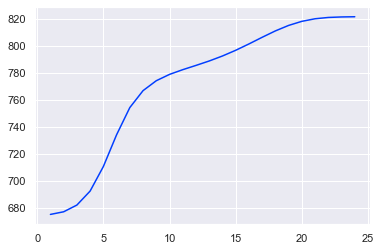

In [27]:
t0 = time.perf_counter()
centers = fit_centroids(data_cut, z_cut, num_centroids=3, num_epochs=40)
duration = time.perf_counter() - t0
print(f"Trained in {duration} seconds")

Text(0, 0.5, 'y')

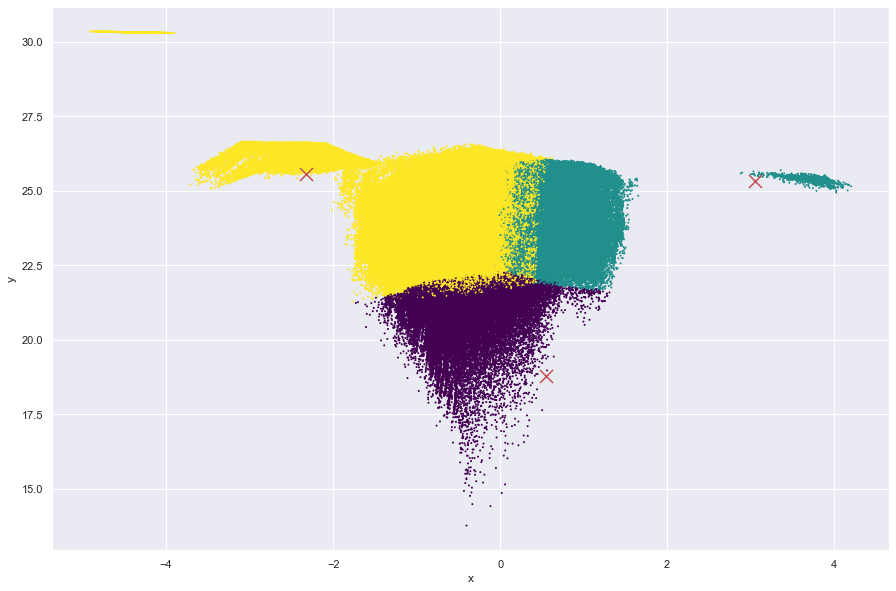

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

y_train = classify(data_cut, centers)

# Plotting data itself.
ax.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=y_train, cmap="viridis_r")
ax.scatter(centers[:, 0], centers[:, 1], marker='x', s=169, linewidths=3,
            color='r', zorder=10)
ax.set_xlabel("x")
ax.set_ylabel("y")

Epoch 1
SNR 698.9847704174516
Epoch 2
SNR 701.6696652623023
2.6848948448506462
Epoch 3
SNR 706.9005812688604
5.230916006558118
Epoch 4
SNR 714.4596700990248
7.559088830164455
Epoch 5
SNR 723.8293678301723
9.369697731147426
Epoch 6
SNR 734.1994799640826
10.370112133910311
Epoch 7
SNR 744.7313240090565
10.531844044973923
Epoch 8
SNR 754.796238153228
10.064914144171553
Epoch 9
SNR 764.0434797539197
9.24724160069161
Epoch 10
SNR 772.3800366017166
8.336556847796942
Epoch 11
SNR 779.8565266911572
7.476490089440631
Epoch 12
SNR 786.5442631752944
6.68773648413719
Epoch 13
SNR 792.4983555800384
5.95409240474396
Epoch 14
SNR 797.7630271622884
5.264671582250003
Epoch 15
SNR 802.3800566942535
4.617029531965159
Epoch 16
SNR 806.3933995513934
4.013342857139833
Epoch 17
SNR 809.8513168826754
3.457917331282033
Epoch 18
SNR 812.8069508015503
2.9556339188749234
Epoch 19
SNR 815.3173621499935
2.510411348443199
Epoch 20
SNR 817.4412948902693
2.123932740275791
Epoch 21
SNR 819.2363897368223
1.7950948465529

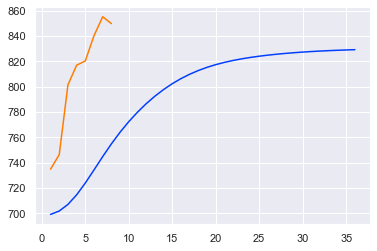

In [14]:
cond = data_cut[:, 1] < reg(data_cut[:, 0])
num_bins = 4
lower_centers = fit_centroids(data_cut[cond], z_cut[cond], num_centroids=num_bins, num_epochs=40)
upper_centers = fit_centroids(data_cut[np.invert(cond)], z_cut[np.invert(cond)], num_centroids=num_bins, num_epochs=40)

Text(0, 0.5, 'y')

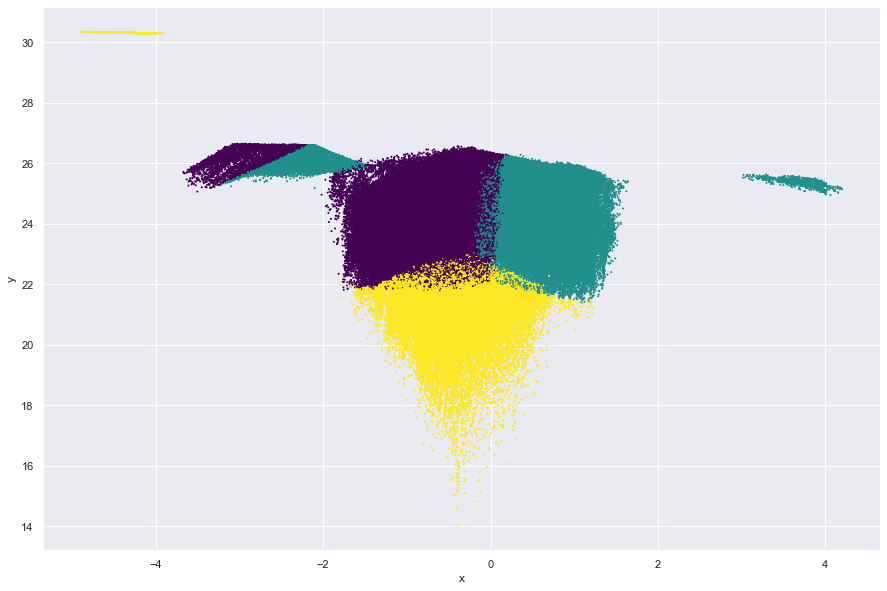

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

y_train_l = classify(data_cut[cond], lower_centers)
y_train_u = classify(data_cut[np.invert(cond)], upper_centers)

# Plotting data itself.
ax.scatter(data_cut[cond][:, 0], data_cut[cond][:, 1], s=1, c=y_train_l, cmap="viridis_r")
ax.scatter(data_cut[np.invert(cond)][:, 0], data_cut[np.invert(cond)][:, 1], s=1, c=y_train_u, cmap="viridis_r")
# ax.scatter(c_0[:, 0], c_0[:, 1], marker='x', s=169, linewidths=3,
#             c="#FF00FF", zorder=9)
# ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3,
#             color='r', zorder=10)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [13]:
def total_classify(points, centroids_l, centroids_u, cond):
    cat_l = classify(points[cond], centroids_l)
    cat_u = classify(points[np.invert(cond)], centroids_u)
    
    total_cat = np.zeros(len(cat_l) + len(cat_u))
    total_cat[cond] = cat_l
    total_cat[np.invert(cond)] = cat_u
    return total_cat

def test_alignment(points, centroids_l, centroids_u, cond, redshift):
    total_cat = total_classify(points, centroids_l, centroids_u, cond)
    total_cat = jax.nn.one_hot(total_cat, total_cat.max() + 1)
    
    return compute_snr_score(total_cat, redshift, binned_nz = True)

In [17]:
# Permutations of the possible centroids.
aligns = np.asarray(list(permutations(range(0, num_bins))))
print(aligns)
snrs = []
for a in aligns:
    snrs.append(test_alignment(data_cut, lower_centers, upper_centers[a], cond, z_cut))
    
print(snrs)
perm = aligns[np.argmax(snrs)]
print(perm)
upper_aligned = upper_centers[perm]

[[0 1 2]
 [0 2 1]
 [1 0 2]
 [1 2 0]
 [2 0 1]
 [2 1 0]]
[DeviceArray(944.54390404, dtype=float64), DeviceArray(955.71858515, dtype=float64), DeviceArray(953.94027154, dtype=float64), DeviceArray(954.40176172, dtype=float64), DeviceArray(935.13870085, dtype=float64), DeviceArray(926.03445235, dtype=float64)]
[0 2 1]


Text(0, 0.5, 'y')

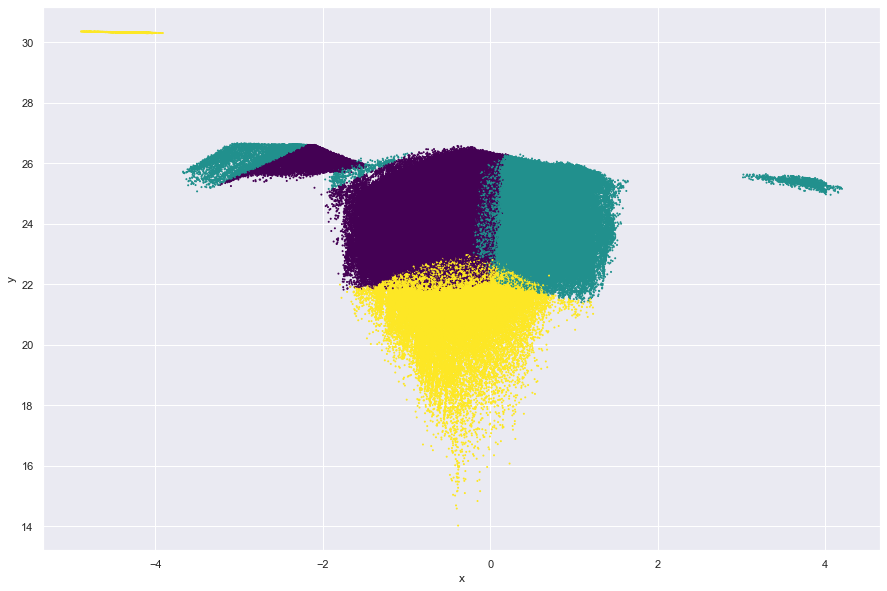

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
y_train = total_classify(data_cut, lower_centers, upper_aligned, cond)

# Plotting data itself.
ax.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=y_train, cmap="viridis_r")
ax.set_xlabel("x")
ax.set_ylabel("y")

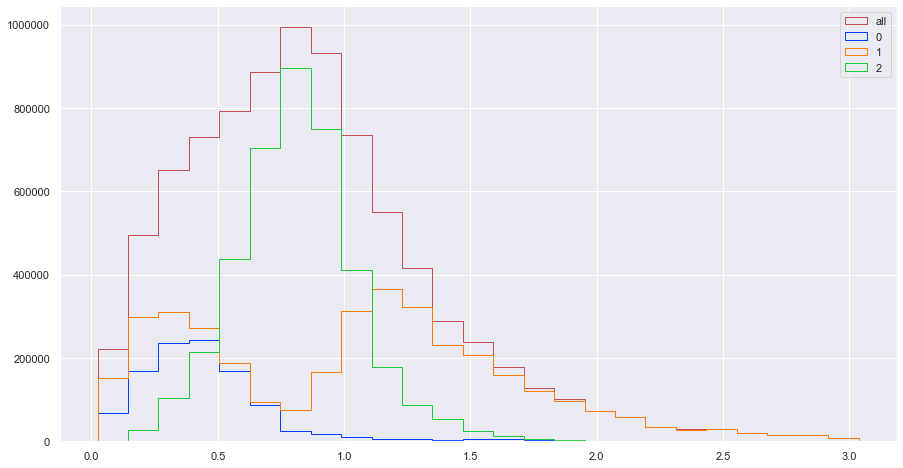

In [19]:
# Predict the categories of the full and uncut dataset and then make a histogram
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.
# Finds the distance between the points and the centroids
total_cond = data_reduced[:, 1] < reg(data_reduced[:, 0])
train_cat = total_classify(data_reduced, lower_centers, upper_aligned, total_cond)

fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_train, bins=25, histtype="step", color="r", label="all")

for i in range(0, int(train_cat.max()) + 1):
    plt.hist(z_train[train_cat == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [29]:
x_valid = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/validation.hdf5", "griz", colors=True))
z_valid = tc.load_redshift(f"{d_loc}/validation.hdf5")

data_valid = x_valid[["r", "gr", "ri", "rz"]].to_numpy()
data_valid_r = data_valid @ reducer

Classified all points in 1.7243933059999108 seconds


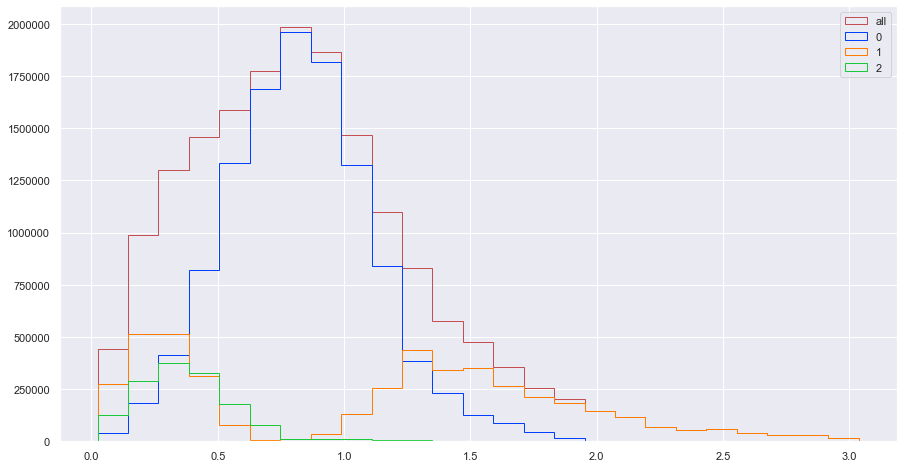

In [30]:
# Predict the categories of the full and uncut dataset and then make a histogram
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.
t0 = time.perf_counter()
valid_cond = data_valid_r[:, 1] < reg(data_valid_r[:, 0])
# y_valid = total_classify(data_valid_r, lower_centers, upper_aligned, valid_cond)

y_valid = classify(data_valid_r, centers)

print(f"Classified all points in {time.perf_counter() - t0} seconds")

fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_valid, bins=25, histtype="step", color="r", label="all")

for i in range(0, int(y_valid.max()) + 1):
    plt.hist(z_valid[y_valid == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [31]:
# Compute those scores.
print(f"Computing the scores for {y_valid.max() + 1} bins.")
t0 = time.perf_counter()
scores = tc.jc_compute_scores(y_valid, z_valid, 
                              metrics=["SNR_ww", "SNR_gg", "SNR_3x2", "FOM_ww", "FOM_gg", "FOM_3x2"])
duration = time.perf_counter() - t0
print(f"{scores} in {duration} seconds")

Computing the scores for 3 bins.
{'SNR_ww': 330.988421195143, 'FOM_ww': 13.164567320995005, 'SNR_gg': 930.5233554524802, 'FOM_gg': 294.6044273060683, 'SNR_3x2': 937.6062213037234, 'FOM_3x2': 971.0836003526928} in 494.4321369680001 seconds


Classifying 6 bins.
Epoch 1
FOM 707.4985340118047
Epoch 2
FOM 715.1104836768858
7.611949665081056
Epoch 3
FOM 730.7124310747556
15.601947397869822
Epoch 4
FOM 751.7124358719965
21.000004797240877
Epoch 5
FOM 772.2023489440234
20.489913072026866
Epoch 6
FOM 787.5947670231118
15.39241807908843
Epoch 7
FOM 797.4752576343786
9.88049061126685
Epoch 8
FOM 803.6341509316334
6.158893297254735
Epoch 9
FOM 807.7901723039932
4.156021372359874
Epoch 10
FOM 810.9954207080714
3.2052484040781337
Epoch 11
FOM 813.793795911704
2.798375203632645
Epoch 12
FOM 816.4398930484712
2.646097136767139
Epoch 13
FOM 819.0219918580644
2.582098809593276
Epoch 14
FOM 821.5198063545754
2.497814496510955
Epoch 15
FOM 823.8404112999115
2.320604945336072
Epoch 16
FOM 825.8580112582371
2.0175999583256043
Epoch 17
FOM 827.4647021541318
1.6066908958947579
Epoch 18
FOM 828.6207967315302
1.1560945773983349
Epoch 19
FOM 829.3822481140378
0.7614513825076301
Epoch 20
FOM 829.8889717506385
0.5067236366006682
Epoch 21
FOM 830.318

/Users/dylan/repos/tomo_challenge/tomo_challenge/metrics.py:152: RuntimeWarning: invalid value encountered in double_scalars
  (bz*nz_bin).sum()/(nz_bin).sum() for nz_bin in n_of_z]


CCLError: Error CCL_ERROR_INTEG: ccl_cls.c: ccl_angular_cls_limber(); integration error


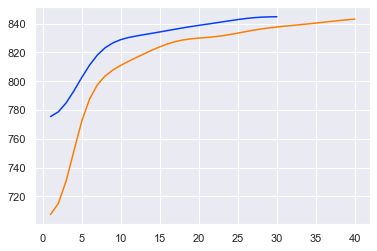

In [43]:
# Compute those scores.
# score_hist_jc = []
# score_hist = []

z_cut = z_train[cut]
for j in range(5, 7):
    clear_output(wait=True)
    print(f"Classifying {j} bins.")
    
    t0 = time.perf_counter()
    centers = fit_centroids(data_cut, z_cut, num_centroids=j, num_epochs=40)
    duration = time.perf_counter() - t0
    print(f"Trained in {duration} seconds")

    y_valid = classify(data_valid_r, centers)
    
    print(f"Computing scores for {j} bins.")
    score_hist_jc.append(tc.jc_compute_scores(y_valid, z_valid, metrics=["SNR_ww", "SNR_gg", "SNR_3x2"]))
    score_hist.append(tc.compute_scores(y_valid, z_valid, metrics=["SNR_ww", "SNR_gg", "SNR_3x2"]))


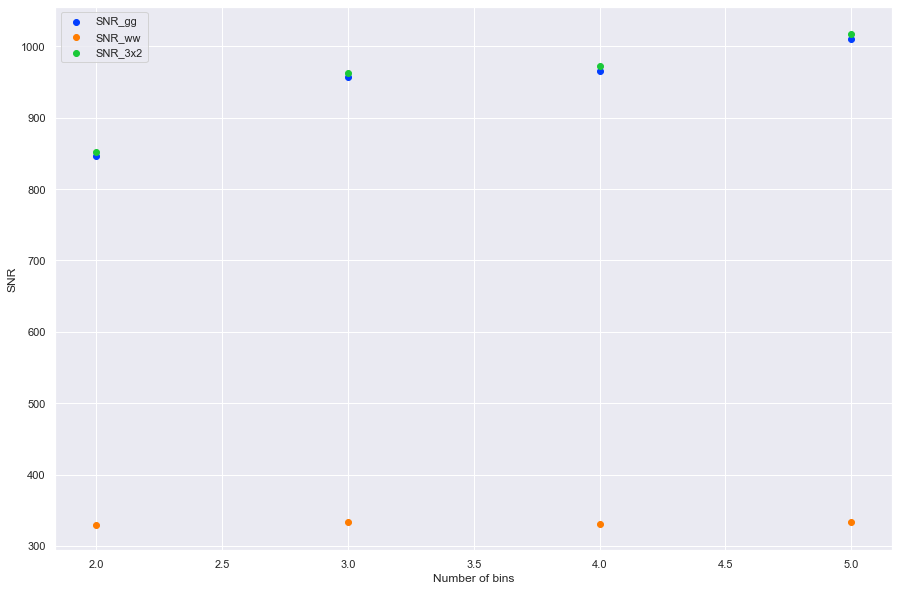

In [44]:
x_hist = np.arange(2, len(score_hist_jc) + 2)
snr_gg = np.asarray([x["SNR_gg"] for x in score_hist_jc])
snr_ww = np.asarray([x["SNR_ww"] for x in score_hist_jc])
snr_32 = np.asarray([x["SNR_3x2"] for x in score_hist_jc])


fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(x_hist, snr_gg, label="SNR_gg")
plt.scatter(x_hist, snr_ww, label="SNR_ww")
plt.scatter(x_hist, snr_32, label="SNR_3x2")
plt.xlabel("Number of bins")
plt.ylabel("SNR")
plt.legend()
plt.savefig("snr_hist.png")